In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

# This script performs the following tasks:
# 1. Reads a cleaned CSV file containing tweet data and weather information.
# 2. Converts the 'tweet_created' column to datetime format for easier manipulation.
# 3. Creates categorical features for weather severity (snowfall, wind speed, precipitation) based on predefined thresholds.
# 4. Converts the categorical severity features into one-hot encoded columns for machine learning compatibility.
# 5. Computes a new feature, 'wind_chill', using a formula that combines temperature and wind speed.
# 6. Extracts temporal features from the 'tweet_created' timestamp, including hour of the day, day of the week, and whether it is a weekend.
# 7. Saves the updated DataFrame with the new features to a new CSV file for further analysis or modeling.

df = pd.read_csv('Input/df_pre-processed.csv')


df['tweet_created'] = pd.to_datetime(df['tweet_created'])


df['snowfall_severity'] = np.where(df['snowfall'] > 1.0, 'heavy_snowfall', 'light_snowfall')
df['wind_severity'] = np.where(df['wind_speed'] > 30.0, 'high_wind', 'low_wind')
df['precipitation_severity'] = np.where(df['precipitation'] > 2.0, 'heavy_rain', 'light_rain')


df = pd.get_dummies(df, columns=['snowfall_severity', 'wind_severity', 'precipitation_severity'], drop_first=True)


df['wind_chill'] = 13.12 + 0.6215 * df['temperature'] - 11.37 * (df['wind_speed'] ** 0.16) + 0.3965 * df['temperature'] * (df['wind_speed'] ** 0.16)


df['hour_of_day'] = df['tweet_created'].dt.hour
df['day_of_week'] = df['tweet_created'].dt.dayofweek  
df['is_weekend'] = np.where(df['day_of_week'].isin([5, 6]), 1, 0)  

# Display the updated DataFrame
print(df.head())


df.to_csv('data_with_new_features.csv', index=False)

             tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570300616901320704          positive                        0.6745   
1  570300248553349120           neutral                        0.6340   
2  570299953286942721          positive                        0.6559   
3  570295459631263746          positive                        1.0000   
4  570289724453216256          positive                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        0.0  Virgin America   
1            NaN                        NaN  Virgin America   
2            NaN                        NaN  Virgin America   
3            NaN                        NaN  Virgin America   
4            NaN                        NaN  Virgin America   

  airline_sentiment_gold          name negativereason_gold  retweet_count  \
0                    NaN    cjmcginnis                 NaN              0   
1                    NaN    

In [3]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
import pandas as pd

# This script performs the following tasks:
# 1. Loads a pre-trained BERT model and tokenizer for generating text embeddings.
# 2. Defines a custom PyTorch Dataset class to handle text data for BERT processing.
# 3. Implements a function to generate BERT embeddings for a list of texts in batches, using mean pooling to aggregate token-level embeddings.
# 4. Computes BERT embeddings for the 'cleaned_text' column of a DataFrame and stores them as a new column.
# 5. Ensures the embeddings are in a proper 2D numpy array format for further use in machine learning pipelines.


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()   


class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]


def get_bert_embeddings(texts, batch_size=32):
    dataset = TextDataset(texts)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_embeddings = []
    with torch.no_grad():
        for batch in dataloader:
            
            inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=128)
            outputs = model(**inputs)
            
            
            embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            all_embeddings.append(embeddings)


    return np.vstack(all_embeddings)

texts = df['cleaned_text'].tolist()  
bert_embeddings = get_bert_embeddings(texts)


assert bert_embeddings.ndim == 2  


df['bert_embedding'] = list(bert_embeddings)  


In [4]:
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()


df['sentiment_encoded'] = le.fit_transform(df['airline_sentiment'])

sentiment_counts = df['sentiment_encoded'].value_counts()


sentiment_labels = le.classes_ 


print(f"Sentiment distribution:\n")
for idx, count in sentiment_counts.items():
    print(f"{sentiment_labels[idx]}: {count}")


Sentiment distribution:

negative: 4769
neutral: 1593
positive: 1330


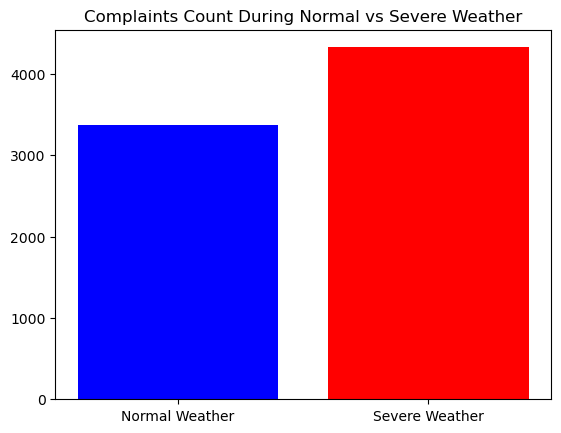

In [5]:
import numpy as np


df['severe_weather'] = ((df['precipitation'] > df['precipitation'].quantile(0.5)) |
                        (df['snowfall'] > df['snowfall'].quantile(0.5)) |
                        (df['wind_speed'] > df['wind_speed'].quantile(0.5)))


complaints_by_weather = df.groupby('severe_weather')['tweet_id'].count()

# Plot
import matplotlib.pyplot as plt
labels = ['Normal Weather', 'Severe Weather']
plt.bar(labels, complaints_by_weather, color=['blue', 'red'])
plt.title("Complaints Count During Normal vs Severe Weather")
plt.show() 



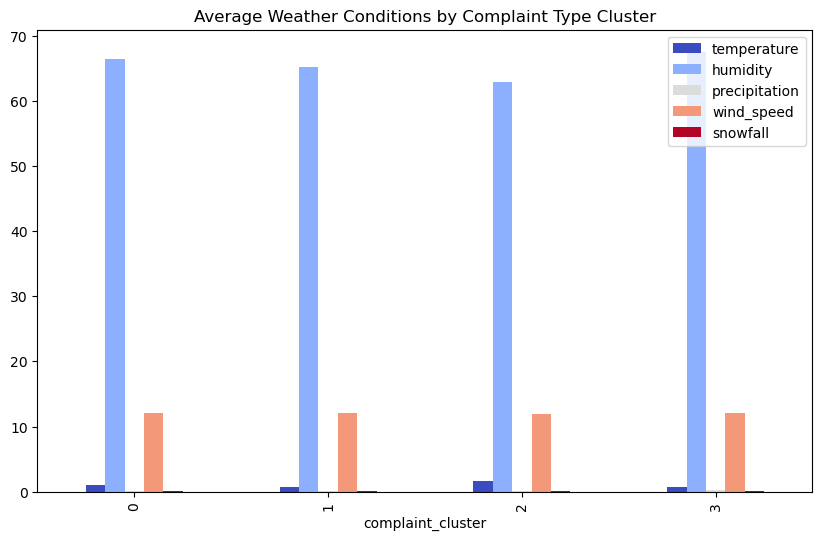

In [6]:
from sklearn.cluster import KMeans
import pandas as pd

kmeans = KMeans(n_clusters=4, random_state=42)
df['complaint_cluster'] = kmeans.fit_predict(list(df['bert_embedding']))


cluster_weather = df.groupby('complaint_cluster')[['temperature', 'humidity', 'precipitation', 'wind_speed', 'snowfall']].mean()

cluster_weather.plot(kind='bar', figsize=(10,6), colormap='coolwarm')
plt.title("Average Weather Conditions by Complaint Type Cluster")
plt.show()

Percentage of Complaints During Adverse Weather Conditions:
                 heavy_snowfall  high_wind heavy_rain
delays                20.103093  16.883117  29.166667
lost_luggage            2.57732   1.298701        0.0
customer_service       9.793814   3.896104   4.166667


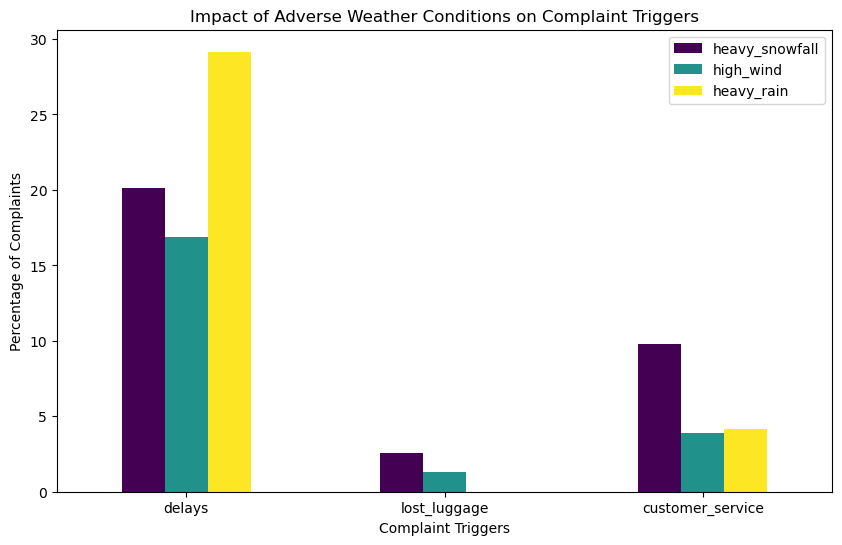

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


trigger_keywords = {
    'delays': ['delay', 'late', 'cancelled', 'on time'],
    'lost_luggage': ['lost luggage', 'baggage', 'missing bag'],
    'customer_service': ['customer service', 'rude', 'unhelpful']
}


for trigger, keywords in trigger_keywords.items():
    df[trigger] = df['cleaned_text'].apply(lambda x: any(keyword in x for keyword in keywords)).astype(int)


df['tweet_created'] = pd.to_datetime(df['tweet_created'])



weather_features = ['temperature', 'humidity', 'precipitation', 'wind_speed', 'snowfall']
triggers = ['delays', 'lost_luggage', 'customer_service']


correlation_data = df[weather_features + triggers]
correlation_matrix = correlation_data.corr()


adverse_weather_conditions = {
    'heavy_snowfall': df['snowfall'] > 1.0,
    'high_wind': df['wind_speed'] > 30.0,
    'heavy_rain': df['precipitation'] > 2.0
}


weather_impact = pd.DataFrame(index=triggers, columns=adverse_weather_conditions.keys())


for trigger in triggers:
    for condition, mask in adverse_weather_conditions.items():
        weather_impact.loc[trigger, condition] = df.loc[mask, trigger].mean() * 100


print("Percentage of Complaints During Adverse Weather Conditions:")
print(weather_impact)


weather_impact.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Impact of Adverse Weather Conditions on Complaint Triggers')
plt.ylabel('Percentage of Complaints')
plt.xlabel('Complaint Triggers')
plt.xticks(rotation=0)
plt.show()

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()


df['sentiment_encoded'] = le.fit_transform(df['airline_sentiment'])


X_weather = df[['snowfall', 'wind_speed', 'precipitation', 'humidity', 'temperature']].values


X_bert = np.array(df['bert_embedding'].tolist())  


if X_bert.ndim == 1:
    X_bert = np.vstack(X_bert)  


X_combined = np.hstack((X_weather, X_bert))  


y = df['sentiment_encoded'].values  

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report



X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.72      0.96      0.82       925
           1       0.61      0.26      0.37       348
           2       0.75      0.42      0.54       266

    accuracy                           0.71      1539
   macro avg       0.69      0.55      0.58      1539
weighted avg       0.70      0.71      0.67      1539



In [10]:
from xgboost import XGBClassifier
model_xg_Boost = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
model_xg_Boost.fit(X_train, y_train)


y_pred_xgboost = model_xg_Boost.predict(X_test)

In [11]:
print(classification_report(y_pred_xgboost, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1124
           1       0.78      0.60      0.68       196
           2       0.91      0.63      0.75       219

    accuracy                           0.88      1539
   macro avg       0.86      0.73      0.78      1539
weighted avg       0.88      0.88      0.87      1539

